> Introducing dynamic Classifier-free Guidance for Diffusion models.

# Introduction

This notebook is an overview of dynamic Classifier-free Guidance, or `dCFG`, for diffusion models.  

We previously ran an [exploratory series](https://enzokro.dev/blog/posts/2022-11-26-guidance-expts-8) on `dCFG` with the `v1` Stable Diffusion models. Then, we made a short introduction notebook on `dCFG` for the [Stable Diffusion v2.0 model](https://enzokro.dev/blog/posts/2022-11-28-sd-v2-schedules-1/). 

With the release of the new and improved `v2-1` Stable Diffusion model, it seems like a great time to take a step back, recap what we've learned so far, and put our approach on more solid footing.  

# Overview of Guidance for Diffusion Models

This section is an overview on generating images based on a known, given input. We shortly recap unconditioned image generation, then move on to classifier-guided generation, and finally close with classifier-free generation. This represents how people have gone from generating random photos to the precise and incredible images based on prompts floating around the web.  

We close with 

## Unconditional Generation

Unconditional image generation is the bedrock of diffusion models. In this case we are given a collection of training images. The goal is to learn and model the probability distribution that generated the images. If we can learn or estimate this distribution, then we can sample from it to create brand new images.  

Ideally, we would have a grand Oracle that can model the distribution of every single possible image. This Oracle would then, in theory, be able to generate absolutely any image we can think of. Unfortunately creating this Oracle would require an almost infinite amount of data, assuming we could even gather it in the first place (we can't). The best we can do is to gather a subset of the images we care the most about. For example, if we are trying to generate outdoor landscapes, we could gather images of nature. The more images we gather the better.  

The goal is to gather a large and diverse image set that represents the topic or subject (aka distribution) that we want to generate. Once we have the training image set, there is a wide range of Machine Learning approaches to model and sample from the image set. The most popular generation approaches are detailed in this [excellent blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) by Lilian Weng. These approaches include:  

- GANs  
- Flow-based models  
- Variational Auto-Encoders  
- Diffusion models  

Assuming our training set is large and representative enough, any of these approaches can learn to model and sample from its data-generating distribution.  

This is fantastic if we want to create new styles of variants of our data. For example, if our training data was of fashion styles, then we could try and generate new or unique trends. Or if the data was some sort of asset like character sprites or objects in a video game, we could generate new and creative items.  

However, we often want to create and generate specific outputs. If you've used any online Stable Diffusion APIs, that's a perfect example. We want the model to specifically generate an output based on the input text. Or, even tying it to our earlier examples, maybe we want a new fashion style that's specifically inspired by certain designers. Likewise for the video game objects or sprites, maybe we can to create a new create that's a blend of two existing monsters. This is where **guidance** comes into play. 

## Classifier Guidance

## Classifier-free Guidance

### Making it dynamic

## What is dCFG actually doing?

# Python imports

We start with a few python imports.

In [ ]:
#| echo: false
#| include: false
%load_ext autoreload
%autoreload 2
import tensorflow as tf
tf.get_logger().setLevel('INFO')

2022-12-10 05:54:22.369428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 05:54:23.052768: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-10 05:54:23.052833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-10 05:54:23.052838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
import os
import gc
import random
from typing import Callable, List, Dict
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Seed for reproducibility

`seed_everything` makes sure that the results are reproducible across notebooks.

In [ ]:
# set the seed for rng
# SEED = 4191151944 
SEED = 1554556204
def seed_everything(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# for sampling the initial, noisy latents
seed_everything(SEED)

# Text prompt for image generations

Negative prompts appear to be very helpful in `v2`. At least, more helpful than they were for `v1.x` models.  

Below, we also borrow a prompt and negative-prompt format that's going around the Stable Diffusion discord. It seems to be a good starting point as the community figures out the new prompt structures. 

In [ ]:
# text prompt for image generations
prompt = "a futuristic metropolis collapsed by the beach on a caribbean island, dystopia, apocalyptic, sci-fi, disaster, art station, misery, cinematic, hdri, matte painting, concept art, soft render, highly detailed, cgsociety, octane render, trending on artstation, architectural HQ, 4k"
# prompt = "One Second Before Awakening From a Dream Provoked by the Flight of a Bee Around a Pomegranate"

# a good negative prompt
# neg_prompt = "!!!!!!text!!!!!!, watermark, bad art, deformed, blurry, strange colours, sketch, lacklustre, repetitive, cropped, lowres, deformed, old, childish"
neg_prompt = "(ugly, cartoon, bad anatomy, bad art, frame, deformed, disfigured, extra limbs, text, meme, low quality, mutated, ordinary, overexposed, pixelated, poorly drawn, signature, thumbnail, too dark, too light, unattractive, useless, watermark, writing, cropped:1.1)"

# Image and Sampler parameters

The images will be generated over $30$ diffusion steps. It will be a rather large `1024 x 1024` output.   

We are using the `DPM++ SDE Karras` sampler with 30 steps. This sampler seems to be working the best for high-quality outputs at the moment. The `2m Karras` schedule wins out on speed, however.  

If the image is too large or the generation is too slow on your machine, I'd suggest bumping down to a `768 x 768` resolution and using the `k_dpmpp_2m` sampler instead.  

In [ ]:
# number of diffusion steps
num_steps = 50    

# image dimensions
height = 768 # 768
width  = 768 # 768

# group the arguments for the generation function
gen_kwargs = {
    'height': height,
    'width': width, 
    'negative_prompt': neg_prompt, 
    'num_steps': num_steps,
}

# set the k-diffusion scheduler
scheduler_kls = 'k_dpmpp_sde'#'k_dpmpp_sde'##'dpm_multi'

# whether to use the Karras sigma schedule
use_karras_sigmas = True

# group scheduler arguments
schedule_kwargs = {
    'scheduler_kls': scheduler_kls,
    'use_karras_sigmas': use_karras_sigmas,
}


# Gathering Stable Diffusion models

For now, the `k_diffusion` integration is only working with the full, `768-v` model. The plan is to eventually support the base model as well.

In [ ]:

# group the different models to run
diffusion_runs = [

    # Stable Diffusion 2
    {'model_name': 'stabilityai/stable-diffusion-2-1',
     'model_kwargs': {
         'unet_attn_slice': True,
         'schedule_kwargs': schedule_kwargs,
    }},

]

# Creating Guidance schedules

### Schedule parameters  

Given how much the prompts have changed in v2, we are back in exploration territory as to what are the best parameters. Exciting times!  

Overall, it seems that the Guidance range is broader in v2. Folks are getting good results with low CFGs (3-5) or with higher values (9+). This is likely highly dependent on both the prompt and negative-prompt. We should know more as the stability.ai team releases their guides and tips.  

In [ ]:
# Default schedule parameters from the blog post
from dynamic_cfg.schedules import DEFAULT_SCHED_PARAMS, DEFAULT_T_PARAMS, get_cos_sched

The functions below quickly build different Guidance schedules. They are also re-used from the [previous notebooks](https://enzokro.dev/blog/posts/2022-11-26-guidance-expts-8/https://enzokro.dev/blog/posts/2022-11-26-guidance-expts-8/). 

In [ ]:
def cos_harness(default_params: dict, new_params: dict) -> dict:
    '''Creates cosine schedules with updated parameters in `new_params`
    '''
    # start from the given baseline `default_params`
    cos_params = dict(default_params)
    # update the with the new, given parameters
    cos_params.update(new_params)
    
    # return the new cosine schedule
    sched = get_cos_sched(**cos_params)
    return sched


def create_expts(params: dict, schedule_name: str) -> List[Dict]:
    '''Creates a list of experiments.
    
    Each element is a dictionary with the name, value, and schedule for a given parameter.
    A `title` field is also added for easy plotting.
    '''
    names = sorted(params)
    expts = []
    # step through parameter names and their values
    for i,name in enumerate(names):
        for j,val in enumerate(params[name]):
            # create the experiment
            expt = {'param_name': name,
                    'val': val,
                    'schedule': schedule_name}
            # name for plotting
            expt['title'] = f'Param: "{name}", val={val}'
            # add it to the experiment list
            expts.append(expt)
    return expts

## Static baselines

First we create the constant, baseline Guidances.  

In [ ]:
# create the baseline schedule with the new function
baseline_sched = 'constant'
baseline_params = {'max_val': [8]}
baseline_expts = create_expts(baseline_params, baseline_sched)

## Improving the baseline with scheduled Guidance

Now we build the most promising dynamic schedule: `Inverse kDecay` with a fast warmup.  

In [ ]:
# creating the inverse kDecay cosine schedules
k_decays = [
    0.1,
    0.2,
    # 0.3,
    # 0.5,
]
inv_k_params = {'k_decay': k_decays}
inv_k_func = 'cos'
inv_k_expts = create_expts(inv_k_params, inv_k_func)

# put all schedules together
all_k_expts = inv_k_expts

# Function to run the experiments

The code below loads the v2 Stable Diffusion model. It's also our harness to easily run many, different experiments. 

In [ ]:
# to load Stable Diffusion pipelines
from dynamic_cfg.diffusion import MinimalDiffusion
# to plot generated images
from dynamic_cfg.utils import show_image, image_grid, plot_grid
# runs dCFG
from dynamic_cfg.guidance import DynamicCFG

In [ ]:
def load_sd_model(model_name, device, dtype, revision, model_kwargs={}):
    '''Loads the given `model_name` Stable Diffusion in `dtype` precision.  
    
    The model is placed on the `device` hardware. 
    Optional `model_kwargs` are passed to the model's load function.
    '''
    pipeline = MinimalDiffusion(model_name, device, dtype, revision, **model_kwargs)
    pipeline.load()
    return pipeline

In [ ]:
def run(pipeline, prompt, schedules, gen_kwargs={},
        norm_name='', show_each=False, test_run=False):
    """Runs a dynamic Classifier-free Guidance experiment. 
    
    Generates an image for the text `prompt` given all the values in `schedules`.
    Uses a Guidance Transformation class from the `cf_guidance` library.  
    Stores the output images with a matching title for plotting. 
    Optionally shows each image as its generated.
    If `test_run` is true, it runs a single schedule for testing. 
    """
    # store generated images and their title (the experiment name)
    images, titles = [], []
    
    # make sure we have a valid guidance transform
    print(f'Using Guidance Normalization: {norm_name}')
    
    # optionally run a single test schedule
    if test_run:
        print(f'Running a single schedule for testing.')
        schedules = schedules[:1]
        
    # run all schedule experiments
    for i,s in enumerate(schedules):
        
        # parse out the title for the current run
        cur_title  = s['title']
        titles.append(cur_title)
        
        # create the guidance transformation 
        sched_name = s['schedule']
        guide_tfm = DynamicCFG(norm_name, sched_name)
        if norm_name in ('t_norm', 'full_norm'):
            guide_tfm.update_sched_kwargs(DEFAULT_T_PARAMS)
        guide_tfm.update_sched_kwargs({s['param_name']: s['val']})
        
        print(f'Running experiment [{i+1} of {len(schedules)}]: {cur_title}...')
        with torch.no_grad(), torch.autocast('cuda'):
            img = pipeline.generate(prompt, dynamic_cfg=guide_tfm, **gen_kwargs)
        images.append(img)
        
        # optionally plot each generated image
        if show_each:
            show_image(img, scale=1)
            
    print('Done.')
    return {'images': images,
            'titles': titles}

# Generating the images

We put together all of the pieces above to generate images with Stable Diffusion v2. Both with our static baseline guidances, and the `Inverse-kDecay` schedules. 

In [ ]:
# stores the generated images
outputs = {}

# load the model on the GPU in full precision
device = 'cuda'
dtype = torch.float16
revision = "fp16"

# step through the Diffusion models
for dparams in diffusion_runs:
    # parse out model name and its custom args
    model_name   = dparams['model_name']
    model_kwargs = dparams['model_kwargs']
    
    # view some info about the run
    print(f'Running model: {dparams}')
    print(f'Generation kwargs: {gen_kwargs}')
    print(f'Using prompt: {prompt}')
    
    # load the current Diffusion model
    pipeline = load_sd_model(model_name, device, dtype, revision, model_kwargs=model_kwargs)
    
    # run the baseline, static Guidance
    baseline_res = run(pipeline, prompt, baseline_expts, gen_kwargs=gen_kwargs,
                       norm_name='no_norm')
    outputs[(model_name,'baseline')] = baseline_res
    
    # run the scheduled Guidances
    base_norm_res = run(pipeline, prompt, all_k_expts, gen_kwargs=gen_kwargs,
                        norm_name='no_norm')
    outputs[(model_name,'scheduled')] = base_norm_res
    
    # # run the scheduled Guidances
    # base_norm_res = run(pipeline, prompt, all_k_expts, gen_kwargs=gen_kwargs,
    #                     norm_name='t_norm')
    # outputs[(model_name,'scheduled_t')] = base_norm_res
                                
    # cleanup GPU memory for the next model
    pipeline = None
    gc.collect()
    del pipeline
    torch.cuda.empty_cache()

Running model: {'model_name': 'stabilityai/stable-diffusion-2-1', 'model_kwargs': {'unet_attn_slice': True, 'schedule_kwargs': {'scheduler_kls': 'k_dpmpp_sde', 'use_karras_sigmas': True}}}
Generation kwargs: {'height': 768, 'width': 768, 'negative_prompt': '(ugly, cartoon, bad anatomy, bad art, frame, deformed, disfigured, extra limbs, text, meme, low quality, mutated, ordinary, overexposed, pixelated, poorly drawn, signature, thumbnail, too dark, too light, unattractive, useless, watermark, writing, cropped:1.1)', 'num_steps': 50}
Using prompt: a futuristic metropolis collapsed by the beach on a caribbean island, dystopia, apocalyptic, sci-fi, disaster, art station, misery, cinematic, hdri, matte painting, concept art, soft render, highly detailed, cgsociety, octane render, trending on artstation, architectural HQ, 4k
Enabling default unet attention slicing.
Using k-diffusion sampler: <dynamic_cfg.kdiff.DPMPPSDESampler object at 0x7f4af0557f10>
Using Guidance Normalization: no_norm
Ru

  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Normalization: no_norm
Running experiment [1 of 2]: Param: "k_decay", val=0.1...
Using negative prompt: (ugly, cartoon, bad anatomy, bad art, frame, deformed, disfigured, extra limbs, text, meme, low quality, mutated, ordinary, overexposed, pixelated, poorly drawn, signature, thumbnail, too dark, too light, unattractive, useless, watermark, writing, cropped:1.1)
Using Karras sigma schedule


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...
Using negative prompt: (ugly, cartoon, bad anatomy, bad art, frame, deformed, disfigured, extra limbs, text, meme, low quality, mutated, ordinary, overexposed, pixelated, poorly drawn, signature, thumbnail, too dark, too light, unattractive, useless, watermark, writing, cropped:1.1)
Using Karras sigma schedule


  0%|          | 0/50 [00:00<?, ?it/s]

Done.


# Results

In [ ]:
#| echo: false

# names of all the models we tried
model_names = [
    'stabilityai/stable-diffusion-2-1',
    
    ##TODO: support base model
    # 'stabilityai/stable-diffusion-2-base',
]

# plot dimensions
plot_height, plot_width = height, width
# for the grid layout
num_scheds = 2
num_rows = 1

def get_results(model_name):
    types = [
        'baseline', 
        'scheduled',
        # 'scheduled_t',
    ]
    return [(outputs[(model_name,t)], t) for t in types]

def plot_all_results(model_name):
    mres = get_results(model_name)
    for i in range(num_scheds):
        image_grid(
            [mres[0][0]['images'][0]] + [o[0]['images'][i] for o in mres[1:]], 
            title=[mres[0][0]['titles'][0]] + [f"{o[0]['titles'][i]}_{o[1]}" for o in mres[1:]],
            rows=num_rows, width=plot_width, height=plot_height
        )
        suptitle = "Inverse-kDecay Cosine" if i else "Constant"
        plt.suptitle(f'Model: {model_name} | {suptitle} Schedule')

## Stable Diffusion v2 images 

Here we plot all of the generated images.  

The image on the left is the baseline with a static, constant Guidance.\
The images on the right are the improvements with Guidance scheduling. Specifically, using the `Inverse-kDecay` cosine schedules with different values of `k`.

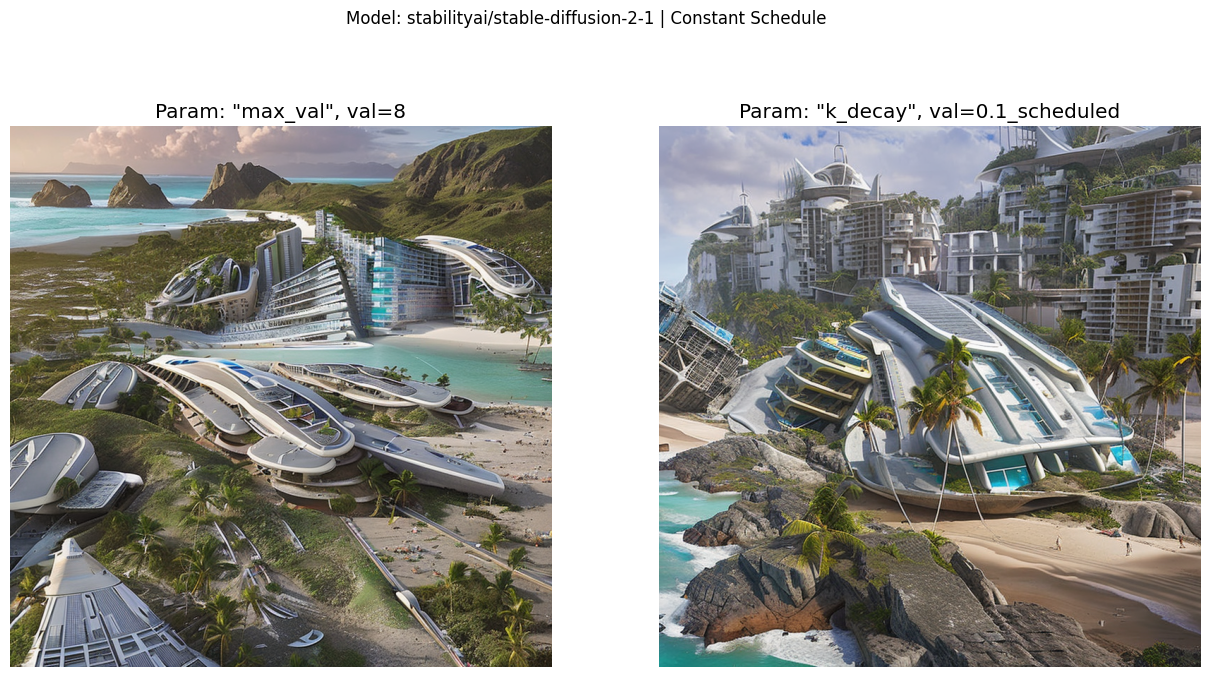

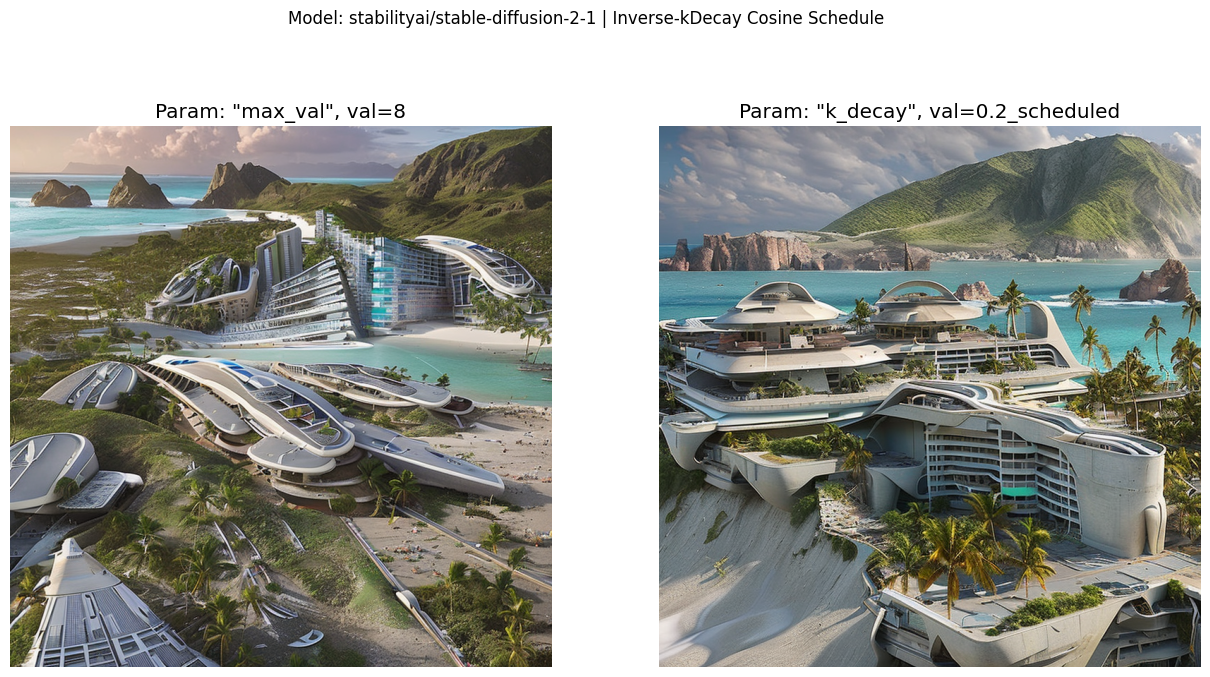

In [ ]:
plot_all_results('stabilityai/stable-diffusion-2-1')

# Conclusion

In this notebook we checked whether scheduling the Classifier-free Guidance improves the images generated by Stable Diffusion v2.  

At first glance, it seems that scheduling still helps! The scheduled generations have a lot more buildings and details. They seem to also better follow the prompt.   